In [7]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.8 MB/s eta 0:00:00


In [19]:
import pydicom
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import skimage.util
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision import models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# root_dir = '/content/drive/MyDrive/MD_Data_Code/Outside_phantom_20_Samples'
# path_to_images = '/content/drive/MyDrive/MD_Data_Code/Outside_phantom_20_Samples/Images_Outside'
# # type(os.listdir(path_to_images))
# path_to_labels = '/content/drive/MyDrive/MD_Data_Code/Outside_phantom_20_Samples/Labels_Outside'

In [4]:
root_dir = '/content/drive/MyDrive/CT_Data/CT_Data'
path_to_images = '/content/drive/MyDrive/CT_Data/CT_Data/Images'
# type(os.listdir(path_to_images))
path_to_labels = '/content/drive/MyDrive/CT_Data/CT_Data/Labels'

In [5]:
os.listdir(path_to_labels)
Au_list, Ca_list, Gd_list,I_list,Lipid_list,Water_list = [],[],[],[],[],[]
for folder in os.listdir(path_to_labels):
  a = os.path.join(path_to_labels,folder)
  for files in os.listdir(a):
    path = os.path.join(a,files)
    label = path.split('/')[-2]
    # print(label)
    if label == '1.3.6.1.4.1.56125.2.32.121.Au':
      Au_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.Ca':
      Ca_list.append(path) 
    if label == '1.3.6.1.4.1.56125.2.32.121.Gd':
      Gd_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.I':
      I_list.append(path) 
    if label == '1.3.6.1.4.1.56125.2.32.121.Lipid':
      Lipid_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.Water':
      Water_list.append(path)    

len(Au_list)
len(Ca_list)  

6

In [6]:
labels = []
for i in range(0,len(Water_list)):
  labels.append([Au_list[i],Ca_list[i],Gd_list[i],I_list[i],Lipid_list[i],Water_list[i]])
len(labels) 

6

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import pydicom

class CT_Material_Dataset(nn.Module):
  def __init__(self,root_dir,labels,transform):
    self.ct_path = os.path.join(root_dir, 'Images')
    self.ct_labels_path = labels
    self.transform = transform
    self.ct_filenames = sorted(os.listdir(self.ct_path))

  def __len__(self):
    return len(self.ct_filenames)

  def __getitem__(self,idx,in_train=True):
    ct_filename = self.ct_filenames[idx]
    # print("ct_filenmae",ct_filename)
    ct_image = (pydicom.read_file(os.path.join(self.ct_path,ct_filename)).pixel_array)/255


    ct_label1 = (pydicom.read_file(self.ct_labels_path[idx][0]).pixel_array)/255
    ct_label2 = (pydicom.read_file(self.ct_labels_path[idx][1]).pixel_array)/255
    ct_label3 = (pydicom.read_file(self.ct_labels_path[idx][2]).pixel_array)/255
    ct_label4 = (pydicom.read_file(self.ct_labels_path[idx][3]).pixel_array)/255
    ct_label5 = (pydicom.read_file(self.ct_labels_path[idx][4]).pixel_array)/255
    ct_label6 = (pydicom.read_file(self.ct_labels_path[idx][5]).pixel_array)/255

    ct_label_all = [ct_label1,ct_label2,ct_label3,ct_label4,ct_label5,ct_label6]
    ct_label_all = np.array(ct_label_all)
    
    ct_image = torch.from_numpy(ct_image)
    ct_label_all = torch.from_numpy(ct_label_all).float()
    if self.transform is not None:
        ct_image = self.transform(ct_image)
        ct_label_all = self.transform(ct_label_all)


    return ct_image, ct_label_all



In [8]:

# Define your transforms for train and valid
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop(size=(260, 260)),
    transforms.GaussianBlur(kernel_size=3),
    # transforms.ToTensor()
])

transform_valid = transforms.Compose([
    # transforms.ToTensor()
    transforms.GaussianBlur(kernel_size=3)
])

In [ ]:
# Split your dataset into train and valid sets
# from torch.utils.data import random_split
# dataset = CT_Material_Dataset(root_dir, labels, transform=None)
# train_size = int(0.8 * len(dataset))
# valid_size = len(dataset) - train_size
# train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
# print(len(train_dataset),len(valid_dataset))

In [9]:
# Create instances of your dataset class for train and valid with different transforms
train_dataset = CT_Material_Dataset(root_dir, labels, transform=transform_train)
valid_dataset = CT_Material_Dataset(root_dir, labels, transform=transform_valid)
print(len(train_dataset),len(valid_dataset))

6 6


In [10]:
# Create dataloaders for train and valid
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

In [11]:
a,b = next(iter(train_loader))
print(a.shape, b.shape)
len(train_loader)

torch.Size([2, 5, 260, 260]) torch.Size([2, 6, 260, 260])


3

In [12]:
a,b = next(iter(valid_loader))
print(a.shape, b.shape)
len(valid_loader)

torch.Size([2, 5, 1260, 1260]) torch.Size([2, 6, 1260, 1260])


3

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model Preperation



In [ ]:
# class ResNet50(nn.Module):
#   def __init__(self,num_classes=6):
#     super().__init__()
#     self.resnet50 = models.resnet50(pretrained=True)
#     self.resnet50.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias=False)
#     self.resnet50.fc = nn.Linear(2048, num_classes)

#   def forward(self,x):
#     x = self.resnet50(x)
#     return x  

# if __name__ == '__main__':
#     model = ResNet50()
#     input = torch.randn(1, 5, 400, 400)
#     output = model(input)
#     print(input.size())
#     print(output.size())

In [8]:
# Creating a UNet for SPCCT (Spectral Photon Counting CT)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        # self.gn1 = nn.GroupNorm(n_groups, in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # self.gn2 = nn.GroupNorm(n_groups, in_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residul = x
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        # x = x + residul

        return x

class UNet2D(nn.Module):
    """2d unet for Material Decomposition
    Ref:
        Material Decomposition using 2d-UNet. Naveed Ilyas
    Args:
        input_shape: tuple, (channel,height, width)
    """

    def __init__(self,in_channels=5, out_channels=6, init_channels=32, p=0.2):
        super(UNet2D, self).__init__()
        #self.input_shape = input_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_channels = init_channels
        self.make_encoder()
        self.make_decoder()
        self.dropout = nn.Dropout(p=p)

    def make_encoder(self):
        init_channels = self.init_channels
        self.conv1a = nn.Conv2d(self.in_channels, init_channels, 3, padding=1)
        self.conv1b = BasicBlock(init_channels, init_channels)  # 32

        self.ds1 = nn.Conv2d(init_channels, init_channels * 2, 3, stride=2, padding=1)  # down sampling and add channels

        self.conv2a = BasicBlock(init_channels * 2, init_channels * 2)
        self.conv2b = BasicBlock(init_channels * 2, init_channels * 2)

        self.ds2 = nn.Conv2d(init_channels * 2, init_channels * 4, 3, stride=2, padding=2)

        self.conv3a = BasicBlock(init_channels * 4, init_channels * 4)
        self.conv3b = BasicBlock(init_channels * 4, init_channels * 4)

        self.ds3 = nn.Conv2d(init_channels * 4, init_channels * 8, 3, stride=2, padding=1)
        # self.ds3 = nn.Conv2d(init_channels * 4, init_channels * 8, 3, stride=2, padding=0)

        self.conv4a = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4b = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4c = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4d = BasicBlock(init_channels * 8, init_channels * 8)

    def make_decoder(self):
        init_channels = self.init_channels
        self.up4conva = nn.Conv2d(init_channels * 8, init_channels * 4, 1)
        self.up4 = nn.Upsample(scale_factor=2)  # mode='bilinear'
        self.up4convb = BasicBlock(init_channels * 4, init_channels * 4)

        self.up3conva = nn.Conv2d(init_channels * 4, init_channels * 2, 1)
        self.up3 = nn.Upsample(scale_factor=2)
        self.up31 = nn.Conv2d(init_channels * 2,init_channels * 2,kernel_size=3,stride=1,padding=0)
        self.up3convb = BasicBlock(init_channels * 2, init_channels * 2)

        self.up2conva = nn.Conv2d(init_channels * 2, init_channels, 1)
        self.up2 = nn.Upsample(scale_factor=2)
        self.up2convb = BasicBlock(init_channels, init_channels)

        self.up1conv = nn.Conv2d(init_channels, self.out_channels, 1)

    def forward(self, x):
        c1 = self.conv1a(x)
        c1 = self.conv1b(c1)
        c1d = self.ds1(c1)

        c2 = self.conv2a(c1d)
        c2 = self.conv2b(c2)
        # print("c2",c2.shape)
        c2d = self.ds2(c2)

        c3 = self.conv3a(c2d)
        c3 = self.conv3b(c3)
        
        c3d = self.ds3(c3)
        # print("c3",c3.shape)
        c4 = self.conv4a(c3d)
        c4 = self.conv4b(c4)
        c4 = self.conv4c(c4)
        c4d = self.conv4d(c4)

        c4d = self.dropout(c4d)

        u4 = self.up4conva(c4d)
        # print("u4",u4.shape)
        u4 = self.up4(u4)
        # print("u4",u4.shape)
        u4 = u4 + c3
        u4 = self.up4convb(u4)

        u3 = self.up3conva(u4)
        u3 = self.up3(u3)
        u3 = self.up31(u3)
        # print("u3",u3.shape)
        u3 = u3 + c2
        u3 = self.up3convb(u3)

        u2 = self.up2conva(u3)
        u2 = self.up2(u2)
        u2 = u2 + c1
        u2 = self.up2convb(u2)

        uout = self.up1conv(u2)
        # uout = F.sigmoid(uout)
        uout = F.softmax(uout)

        return uout

# if __name__ == "__main__":
#     #input  = torch.randn(1,4,160,192,128)
#     input = torch.randn(1, 5, 260, 260)
#     input = torch.randn(1, 5, 1260, 1260)
#     #input = torch.randn(1, 4, 164, 164, 164)
#     #input2 = torch.randn((1,8,100,100,60))
#     model = UNet2D()
#     output = model(input)
#     print(output.shape) 
    # print(output.shape)  

In [33]:
criterion = nn.CrossEntropyLoss()
model = UNet2D()
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
nump_epoch= 2

In [34]:
# Set up a directory to save the model checkpoints
# checkpoint_dir = '/content/drive/MyDrive/MD_Data_Code/Model_Saving/checkpoints'
checkpoint_dir ='/content/drive/MyDrive/CT_Data/CT_Data/Saving_Models'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


train_loss_list, valid_loss_list = [],[]
min_valid_loss = 1000000
for epoch in range(nump_epoch):
  train_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # labels = labels.argmax(dim=1) 
    # print(images.shape, labels.shape)
    # print(images.shape, labels.shape)
    output =  model(images.float())
    # output =  model(images)
    optimizer.zero_grad()
    loss = criterion(output,labels)
    # loss += loss.item()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    valid_loss = 0
    model.eval()
    for i, data in enumerate(valid_loader):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      output = model(images.float())
      loss = criterion(output,labels)
      valid_loss += loss.item()
    print(f'Epoch {epoch} \t\t Training loss: {train_loss/len(train_loader)} \t\t Valid loss: {valid_loss/len(valid_loader)}')
    if min_valid_loss > valid_loss:
      print(f'Validation Loss Decreased: {min_valid_loss:.6f} \t\t {valid_loss:.6f}')
      min_valid_loss = valid_loss
      # torch.save(model.state_dict(), '/content/drive/MyDrive/MD_Data_Code/Model_Saving/saved_model_UNet.pth')
      checkpoint = {"epoch":{epoch},
                    "model_state_dict":model.state_dict(),
                    "loss":valid_loss}
      torch.save(checkpoint,checkpoint_dir+'my_model_checkpoint_{}.pth'.format(epoch))              

  train_loss_list.append(train_loss/len(train_loader))
  valid_loss_list.append(valid_loss/len(valid_loader))

<ipython-input-14-cb4fe42f3fde>:129: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  uout = F.softmax(uout)


Epoch 0 		 Training loss: 22.478098551432293 		 Valid loss: 18.49472999572754
Validation Loss Decreased: 1000000.000000 		 55.484190
Epoch 0 		 Training loss: 31.519665400187176 		 Valid loss: 17.38440195719401
Validation Loss Decreased: 55.484190 		 52.153206
Epoch 0 		 Training loss: 45.42335446675619 		 Valid loss: 17.372819900512695
Validation Loss Decreased: 52.153206 		 52.118460
Epoch 1 		 Training loss: 11.624150594075521 		 Valid loss: 17.372819900512695
Epoch 1 		 Training loss: 26.180503845214844 		 Valid loss: 17.37282117207845
Epoch 1 		 Training loss: 38.049303690592446 		 Valid loss: 17.372819264729817
Validation Loss Decreased: 52.118460 		 52.118458


In [ ]:
import pickle

# Declare a list variable
my_list = [1, 2, 3, 4, 5]

# Write the list to memory
with open('/content/drive/MyDrive/MD_Data_Code/Model_Saving/train_loss_list.pkl', 'wb') as f:
    pickle.dump(train_loss_list, f)

with open('/content/drive/MyDrive/MD_Data_Code/Model_Saving/valid_loss_list.pkl', 'wb') as f:
    pickle.dump(valid_loss_list, f)    

# Read the list from memory
with open('/content/drive/MyDrive/MD_Data_Code/Model_Saving/train_loss_list.pkl', 'rb') as f:
    train_loss_list_from_memory = pickle.load(f)

with open('//content/drive/MyDrive/MD_Data_Code/Model_Saving/valid_loss_list.pkl', 'rb') as f:
    valid_loss_list_from_memory = pickle.load(f)

    

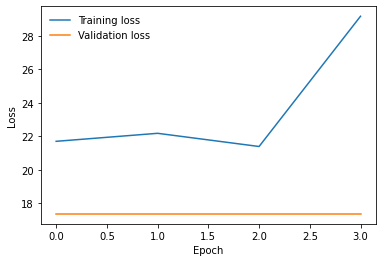

In [17]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

(6, 1260, 1260)


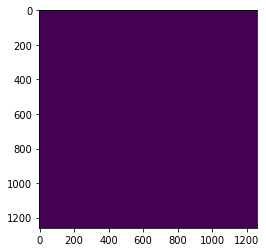

In [38]:
import matplotlib.pyplot as plt
output.shape
out_tensor = output[0]
out_numpy = out_tensor.cpu().detach().numpy()
print(out_numpy.shape)

plt.imshow(out_numpy[5,:,:])
plt.show()

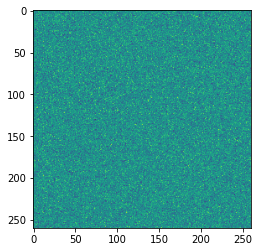

In [23]:
import matplotlib.pyplot as plt
import torch

out = torch.randn(4, 6, 260, 260)
out_numpy = out[0].cpu().detach().numpy()
out_numpy.shape

import matplotlib.pyplot as plt
plt.imshow(out_numpy[3,:,:])
plt.show()

**Testing the Trained Model**

In [38]:
# Normalize the test data to have zero mean and unit variance
# test_data = (test_data - np.mean(test_data)) / np.std(test_data)

In [8]:
import pydicom
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import skimage.util
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision import models

In [9]:
root_dir = '/content/drive/MyDrive/CT_Data/CT_Data'
path_to_images = '/content/drive/MyDrive/CT_Data/CT_Data/Images'
# type(os.listdir(path_to_images))
path_to_labels = '/content/drive/MyDrive/CT_Data/CT_Data/Labels'

In [10]:
os.listdir(path_to_labels)
Au_list, Ca_list, Gd_list,I_list,Lipid_list,Water_list = [],[],[],[],[],[]
for folder in os.listdir(path_to_labels):
  a = os.path.join(path_to_labels,folder)
  for files in os.listdir(a):
    path = os.path.join(a,files)
    label = path.split('/')[-2]
    # print(label)
    if label == '1.3.6.1.4.1.56125.2.32.121.Au':
      Au_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.Ca':
      Ca_list.append(path) 
    if label == '1.3.6.1.4.1.56125.2.32.121.Gd':
      Gd_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.I':
      I_list.append(path) 
    if label == '1.3.6.1.4.1.56125.2.32.121.Lipid':
      Lipid_list.append(path)
    if label == '1.3.6.1.4.1.56125.2.32.121.Water':
      Water_list.append(path)    

len(Au_list)
len(Ca_list)  

6

In [11]:
labels = []
for i in range(0,len(Water_list)):
  labels.append([Au_list[i],Ca_list[i],Gd_list[i],I_list[i],Lipid_list[i],Water_list[i]])
len(labels) 

6

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import pydicom

class CT_Material_Dataset(nn.Module):
  def __init__(self,root_dir,labels,transform):
    self.ct_path = os.path.join(root_dir, 'Images')
    self.ct_labels_path = labels
    self.transform = transform
    self.ct_filenames = sorted(os.listdir(self.ct_path))

  def __len__(self):
    return len(self.ct_filenames)

  def __getitem__(self,idx,in_train=True):
    ct_filename = self.ct_filenames[idx]
    # print("ct_filenmae",ct_filename)
    ct_image = (pydicom.read_file(os.path.join(self.ct_path,ct_filename)).pixel_array)/255


    ct_label1 = (pydicom.read_file(self.ct_labels_path[idx][0]).pixel_array)/255
    ct_label2 = (pydicom.read_file(self.ct_labels_path[idx][1]).pixel_array)/255
    ct_label3 = (pydicom.read_file(self.ct_labels_path[idx][2]).pixel_array)/255
    ct_label4 = (pydicom.read_file(self.ct_labels_path[idx][3]).pixel_array)/255
    ct_label5 = (pydicom.read_file(self.ct_labels_path[idx][4]).pixel_array)/255
    ct_label6 = (pydicom.read_file(self.ct_labels_path[idx][5]).pixel_array)/255

    ct_label_all = [ct_label1,ct_label2,ct_label3,ct_label4,ct_label5,ct_label6]
    ct_label_all = np.array(ct_label_all)
    
    ct_image = torch.from_numpy(ct_image)
    ct_label_all = torch.from_numpy(ct_label_all).float()
    if self.transform is not None:
        ct_image = self.transform(ct_image)
        ct_label_all = self.transform(ct_label_all)


    return ct_image, ct_label_all



In [13]:
test_dataset = CT_Material_Dataset(root_dir, labels, transform=None)

In [14]:
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [15]:
a,b = next(iter(test_loader))
print(a.shape, b.shape)
len(test_loader)

torch.Size([2, 5, 1260, 1260]) torch.Size([2, 6, 1260, 1260])


3

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Creating a UNet for SPCCT (Spectral Photon Counting CT)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        # self.gn1 = nn.GroupNorm(n_groups, in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # self.gn2 = nn.GroupNorm(n_groups, in_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residul = x
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        # x = x + residul

        return x

class UNet2D(nn.Module):
    """2d unet for Material Decomposition
    Ref:
        Material Decomposition using 2d-UNet. Naveed Ilyas
    Args:
        input_shape: tuple, (channel,height, width)
    """

    def __init__(self,in_channels=5, out_channels=6, init_channels=32, p=0.2):
        super(UNet2D, self).__init__()
        #self.input_shape = input_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_channels = init_channels
        self.make_encoder()
        self.make_decoder()
        self.dropout = nn.Dropout(p=p)

    def make_encoder(self):
        init_channels = self.init_channels
        self.conv1a = nn.Conv2d(self.in_channels, init_channels, 3, padding=1)
        self.conv1b = BasicBlock(init_channels, init_channels)  # 32

        self.ds1 = nn.Conv2d(init_channels, init_channels * 2, 3, stride=2, padding=1)  # down sampling and add channels

        self.conv2a = BasicBlock(init_channels * 2, init_channels * 2)
        self.conv2b = BasicBlock(init_channels * 2, init_channels * 2)

        self.ds2 = nn.Conv2d(init_channels * 2, init_channels * 4, 3, stride=2, padding=2)

        self.conv3a = BasicBlock(init_channels * 4, init_channels * 4)
        self.conv3b = BasicBlock(init_channels * 4, init_channels * 4)

        self.ds3 = nn.Conv2d(init_channels * 4, init_channels * 8, 3, stride=2, padding=1)
        # self.ds3 = nn.Conv2d(init_channels * 4, init_channels * 8, 3, stride=2, padding=0)

        self.conv4a = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4b = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4c = BasicBlock(init_channels * 8, init_channels * 8)
        self.conv4d = BasicBlock(init_channels * 8, init_channels * 8)

    def make_decoder(self):
        init_channels = self.init_channels
        self.up4conva = nn.Conv2d(init_channels * 8, init_channels * 4, 1)
        self.up4 = nn.Upsample(scale_factor=2)  # mode='bilinear'
        self.up4convb = BasicBlock(init_channels * 4, init_channels * 4)

        self.up3conva = nn.Conv2d(init_channels * 4, init_channels * 2, 1)
        self.up3 = nn.Upsample(scale_factor=2)
        self.up31 = nn.Conv2d(init_channels * 2,init_channels * 2,kernel_size=3,stride=1,padding=0)
        self.up3convb = BasicBlock(init_channels * 2, init_channels * 2)

        self.up2conva = nn.Conv2d(init_channels * 2, init_channels, 1)
        self.up2 = nn.Upsample(scale_factor=2)
        self.up2convb = BasicBlock(init_channels, init_channels)

        self.up1conv = nn.Conv2d(init_channels, self.out_channels, 1)

    def forward(self, x):
        c1 = self.conv1a(x)
        c1 = self.conv1b(c1)
        c1d = self.ds1(c1)

        c2 = self.conv2a(c1d)
        c2 = self.conv2b(c2)
        # print("c2",c2.shape)
        c2d = self.ds2(c2)

        c3 = self.conv3a(c2d)
        c3 = self.conv3b(c3)
        
        c3d = self.ds3(c3)
        # print("c3",c3.shape)
        c4 = self.conv4a(c3d)
        c4 = self.conv4b(c4)
        c4 = self.conv4c(c4)
        c4d = self.conv4d(c4)

        c4d = self.dropout(c4d)

        u4 = self.up4conva(c4d)
        # print("u4",u4.shape)
        u4 = self.up4(u4)
        # print("u4",u4.shape)
        u4 = u4 + c3
        u4 = self.up4convb(u4)

        u3 = self.up3conva(u4)
        u3 = self.up3(u3)
        u3 = self.up31(u3)
        # print("u3",u3.shape)
        u3 = u3 + c2
        u3 = self.up3convb(u3)

        u2 = self.up2conva(u3)
        u2 = self.up2(u2)
        u2 = u2 + c1
        u2 = self.up2convb(u2)

        uout = self.up1conv(u2)
        # uout = F.sigmoid(uout)
        uout = F.softmax(uout)

        return uout

# if __name__ == "__main__":
#     #input  = torch.randn(1,4,160,192,128)
#     input = torch.randn(1, 5, 260, 260)
#     input = torch.randn(1, 5, 1260, 1260)
#     #input = torch.randn(1, 4, 164, 164, 164)
#     #input2 = torch.randn((1,8,100,100,60))
#     model = UNet2D()
#     output = model(input)
#     print(output.shape) 
    # print(output.shape)  

In [21]:
import torch
checkpoint_path = '/content/drive/MyDrive/CT_Data/CT_Data/Saving_Modelsmy_model_checkpoint_2.pth'
checkpoint = torch.load(checkpoint_path)
# checkpoint['model_state_dict']['']['loss']
checkpoint.keys()
model = UNet2D()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
valid_loss = 0
for i, data in enumerate(test_loader):
  images, labels = data
  images = images.to(device)
  labels = labels.to(device)
  predicted_output = model(images.float())
  loss = criterion(predicted_output,labels)
  valid_loss += loss.item()
print(f' \t\t Valid loss: {valid_loss/len(test_loader)}')

<ipython-input-17-cb4fe42f3fde>:129: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  uout = F.softmax(uout)


 		 Valid loss: 17.372819900512695


(6, 1260, 1260)


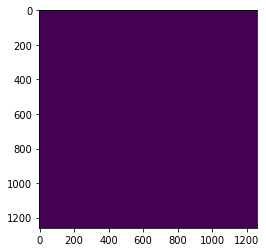

In [23]:
import matplotlib.pyplot as plt
predicted_output.shape
out_tensor = predicted_output[0]
out_numpy = out_tensor.cpu().detach().numpy()
print(out_numpy.shape)

plt.imshow(out_numpy[3,:,:])
plt.show()